# PH7013
Sample code from https://qutip.org/docs/latest/guide/dynamics/dynamics-time.html

In [247]:
import numpy as np
from qutip import *
%matplotlib inline
import matplotlib.pyplot as plt
from qutip.qip.pulse import Pulse
from qutip.qip.device import Processor
from scipy.signal import argrelextrema

In [166]:
with open("rename.py") as f:
    exec(f.read())

## My code

Parameters

In [234]:
VStd = 0.01
phaseStd = 0.382 / 180 * np.pi
detuningStd = 52769

omega = 20e6 # 20MHz
VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

V = VNaught + np.random.normal(scale=VStd)
phi = phiNaught + np.random.normal(scale=phaseStd)
I = np.cos(phi)
Q = np.sin(phi)

Finding the pulse duration. When specifying Python functions for coefficients, the function must have (t,args) as the input variables, in that order.

In [235]:
t_final = 200e-9
t_find_pulse = np.linspace(0.0, t_final, 100)
def H_find_pulse(t, args):
    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / t_final)
    return omega * np.pi * V * s *((-I * np.cos(dwt) + Q * np.sin(dwt)) * tensor(identity(2),sigma_x()) + (I * np.sin(dwt) - Q * np.cos(dwt)) * tensor(identity(2),sigma_y()))
result_find_pulse = sesolve(H_find_pulse, psi0, t_find_pulse, [tensor(sigmaz(),sigmaz())],options=Options(nsteps=10000))

In [236]:
maximum_array = argrelextrema(result_find_pulse.expect[0], np.greater)
minimum_array = argrelextrema(result_find_pulse.expect[0], np.less)
first_max = maximum_array[0][0]
first_min = minimum_array[0][0]
pi_pulse_duration = np.absolute(result_find_pulse.times[first_min] - result_find_pulse.times[first_max])

Solving the Hamiltonian

In [237]:
def H(t, args):
    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / pi_pulse_duration)
    return omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * tensor(identity(2),sigma_x()) + (I * np.sin(dwt) - Q * np.cos(dwt)) * tensor(identity(2),sigma_y()))

Text(0, 0.5, 'Expectation Value')

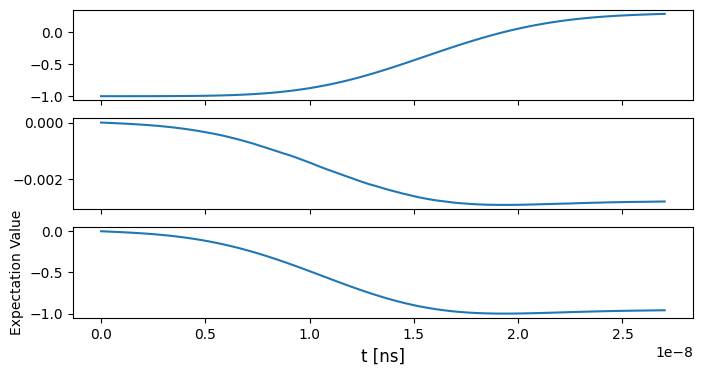

In [241]:
t = np.linspace(0.0, pi_pulse_duration, 100)
result = sesolve(H, psi0, t, [tensor(identity(2),sigmaz()),tensor(identity(2),sigmax()),tensor(identity(2),sigmay())],options=Options(nsteps=10000))
plot_expectation_values(result)
plt.xlabel("t [ns]")
plt.ylabel("Expectation Value")

## Randomize Benchmarking

In [ ]:
x_rotation = lambda theta: np.matrix([
    [np.cos(theta / 2),        -1j * np.sin(theta/2)],
    [-1j * np.sin(theta / 2),  np.cos(theta / 2)]
])

y_rotation = lambda theta: np.matrix([
    [np.cos(theta / 2), -np.sin(theta / 2)],
    [np.sin(theta / 2), np.cos(theta / 2)]
])

In [248]:
processor = Processor(2)
coeff=np.array([0.1, 0.2, 0.4, 0.5])
tlist=np.array([[1.0, 1.5, 2.0], [1.8, 1.3, 0.8]])
pulse = Pulse(sigmaz(), targets=0, coeff=coeff, tlist=tlist)
processor.add_pulse(pulse)

In [251]:
import matplotlib.pyplot as plt
import numpy as np
import qutip_qip
from qutip import (Qobj, Options, basis, fock_dm, qeye, sigmax, sigmay,
                   sigmaz, tensor)
from qutip.ipynbtools import version_table
from qutip_qip.circuit import QubitCircuit
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor
from qutip_qip.noise import Noise
from qutip_qip.operations import Gate
from scipy.optimize import curve_fit

ModuleNotFoundError: No module named 'Cython'

In [252]:
import sys
!{sys.executable} -m pip install Cython

                                              0.0/2.8 MB ? eta -:--:--
     --------------                           1.0/2.8 MB 20.5 MB/s eta 0:00:01
     --------------------------------------   2.7/2.8 MB 28.3 MB/s eta 0:00:01
     ---------------------------------------- 2.8/2.8 MB 22.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: C:\Users\XPS13-9360\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
